In [1]:
import math
import os
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ot import emd2
from pyxdameraulevenshtein import damerau_levenshtein_distance

from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
cmap = sns.light_palette('azure', input='xkcd')

In [3]:
def floyd(mt):
    res = mt.copy()
    n = len(mt)
    for i in range(n):
        for k in range(n):
            if i == k: continue
            for j in range(n):
                if i == j or j == k: continue
                if res[i, j] > res[i, k] + res[k, j]:
                    res[i, j] = res[i, k] + res[k, j]
    return res

def get_curvature(mt):
    n = len(mt)
    hop = floyd(np.vectorize(lambda x: n + 1 if x == 0 else 1)(mt))
    for i in range(n):
        hop[i, i] = 0
    piles = [[w / row.sum() for w in row] for row in mt]
    res = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if hop[i, j] != 0:
                res[i, j] = 1 - emd2(piles[i], piles[j], hop) / hop[i, j]
    return res

def upper_triangle(mt):
    res = []
    for i in range(mt.shape[0]):
        for j in range(i + 1, mt.shape[1]):
            res.append(mt[i, j])
    return np.array(res)

def levenshtein(a, b):
    return damerau_levenshtein_distance(list(a), list(b))

def show_accuracy(y_test, y_pred):
    print('Точность: ', round(accuracy_score(y_test, y_pred), 3))
    conf_mt = confusion_matrix(y_test, y_pred)
    labels = ['CTL', 'PNT']
    ax = plt.subplot()
    sns.heatmap(conf_mt, annot=True, ax=ax, cmap=cmap)
    ax.set_xlabel('Предсказание')
    ax.set_ylabel('На самом деле')
    ax.set_title('Ошибки')
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360)
    plt.show()

In [5]:
vertex_curvature = []
edge_curvature = []
y = []

for i, (a, b) in enumerate([('controls', 'ctrl'), ('patients', 'pat')]):
    dirname = 'Alzheimer/AD_'+a+'_corr_mats/'
    n = len(os.listdir(dirname))
    curvature = [get_curvature(np.load(dirname+b+'_'+str(j)+'.npy')) for j in range(n)]

    vertex_curvature.append([c.mean(axis=1) for c in curvature])
    edge_curvature.append([upper_triangle(c) for c in curvature])
    y.append([i] * n)

vertex_curvature = np.concatenate(vertex_curvature)
edge_curvature = np.concatenate(edge_curvature)
y = np.concatenate(y)

In [8]:
def predict(Predictor, prep_X, X0_tr, X0_ts, y_tr, y_ts):
    X = prep_X(X0_tr)
    X_tr = X(X0_tr)
    X_ts = X(X0_ts)
    pred = Predictor().fit(X_tr, y_tr).predict(X_ts)
    return (y_ts, pred)

Точность:  0.516


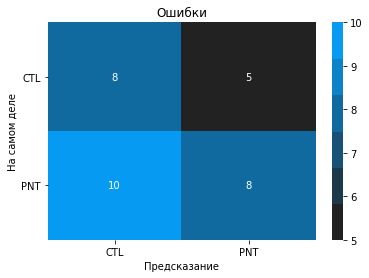

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def LogReg():
    return LogisticRegression()

def histo(x):
    return np.array([ np.histogram(y, bins=1000, range=(-1, 1))[0] for y in x ])

def prep(src):
    sc = PCA().fit(histo(src)).transform
    return lambda x: sc(histo(x))

show_accuracy(*predict(LogReg, prep, *train_test_split(vertex_curvature, y, test_size=0.2)))